# Autoencoders

## NeuroWorkshop v2

by [Dmitri Soshnikov](http://fb.com/shwars)

<http://github.com/shwars/neuroworkshop>


Автоэнкодеры - это попытка пример **self-supervised learning**, когда вместо обучающих примеров мы подаём на вход и выход сети одинаковые данные. Общая идея состоит в том, что мы создаём функцию-кодировщик (*encoder*), которая преобразует данные в некоторое состояние (как правило вектор меньшей размерности), и затем функцию-декодировщик (*decoder*), которая на выходе пытается получить исходное изображение.

Таким образом сеть пытается найти эмбеддинг исходных данных, который сохранял бы их смысл.

![AutoEncoder Diagram](http://blog.keras.io/img/ae/autoencoder_schema.jpg)

Данные примеры во многом заимствованы из [этой прекрасной статьи](https://blog.keras.io/building-autoencoders-in-keras.html).

Важные свойства автоэнкодеров:

* **Data Specific** - они хорошо работают с теми данными, на которых были обучены (не очень подходят для сжатия произвольных данных)
* **Lossy** - воспроизведенное изображение не идентично исходному. Близость изображений определяется функцией потерь (*loss function*) которая использовалась при обучении.
* **Обучение на примерах без разметки**

Основные сценарии использования автоэнкодеров:

* **Уменьшение размерности данных для визуализации**. Обычно удаётся получить более интересные результаты, чем в случае PСA
* **Удаление шумов с изображений**
* **Генеративные модели**

Реализуем простейший автоэнкодер для MNIST:

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_trainclass), (x_test, y_testclass) = mnist.load_data()

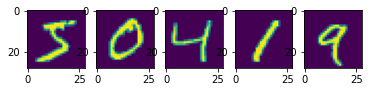

In [2]:
def plotn(n,x):
  fig,ax = plt.subplots(1,n)
  for i,z in enumerate(x[0:n]):
    ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
  plt.show()
  
plotn(5,x_train)

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy,mse

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [131]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59648/60000 [============================>.] - ETA: 0s - loss: 0.2134

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 6s 99us/sample - loss: 0.2130 - val_loss: 0.1454
Epoch 2/25
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1353 - val_loss: 0.1258
Epoch 3/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1225 - val_loss: 0.1177
Epoch 4/25
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1163 - val_loss: 0.1126
Epoch 5/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1120 - val_loss: 0.1091
Epoch 6/25
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1093 - val_loss: 0.1070
Epoch 7/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1072 - val_loss: 0.1055
Epoch 8/25
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1057 - val_loss: 0.1041
Epoch 9/25
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1045 - val_loss: 0.1028
Epoch 10/25
60000/60000 [=======================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


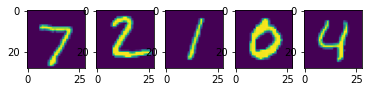

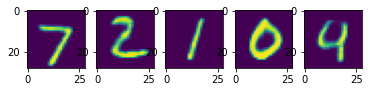

In [132]:
y_test = autoencoder.predict(x_test[0:5])
plotn(5,x_test)
plotn(5,y_test)

In [133]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test[0:5])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


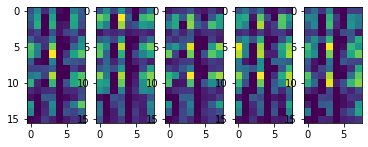

In [134]:
plotn(5,encoded_imgs.reshape(5,-1,8))

6.3110805 0.0


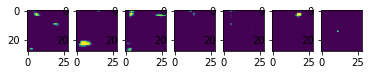

In [136]:
print(encoded_imgs.max(),encoded_imgs.min())
res = decoder.predict(7*np.random.rand(7,4,4,8))
plotn(7,res)

> **Задание**: Попробуйте обучить автоэнкодер с небольшой размерностью латентного слоя, например 2, и построить распределение всех точек, соответствующих разным цифрам. *Подсказка: Для этого нужно использовать после свёрточных слоёв полносвязный для уменьшения размерности до нужных значений.*

> **Задание 2**: Получите значения латентного пространства для каких-то входных цифр, и посмотрите, как влияет добавление небольшого шума к вектору латентного пространства, какие в результате декодирования получаются изображения.

## Denoising

Для удаления шума с картинок также можно эффективно использовать автоэнкодер, который обучается на паре из зашумлённой - не зашумлённой картинки. Для этого добавим к данным MNISТ белый шум: 

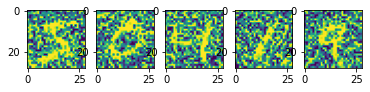

In [137]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [141]:
autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 6s 101us/sample - loss: 0.1576 - val_loss: 0.1566
Epoch 2/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1564 - val_loss: 0.1553
Epoch 3/25
60000/60000 [==============================] - 6s 94us/sample - loss: 0.1555 - val_loss: 0.1539
Epoch 4/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1545 - val_loss: 0.1530
Epoch 5/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1538 - val_loss: 0.1517
Epoch 6/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1528 - val_loss: 0.1506
Epoch 7/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1521 - val_loss: 0.1499
Epoch 8/25
60000/60000 [==============================] - 5s 92us/sample - loss: 0.1514 - val_loss: 0.1495
Epoch 9/25
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1508 - val

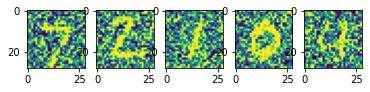

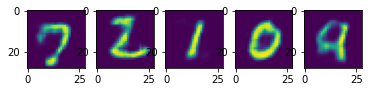

In [144]:
y_test = autoencoder.predict(x_test_noise[0:5])
plotn(5,x_test_noise)
plotn(5,y_test)

> **Задание:** Посмотрите, как обученное на цифрах шумоподавление работает на других картинках. В качестве примера можно взять датасет [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/). Убедитесь, что шумоподавляющий автоэнкодер хорошо работает только на том типе картинок, на котором был обучен (т.е. для того же вероятностного распределения входных параметров).

## Super-resolution

По аналогии с шумоподавлением, автоэнкодеры могут применяться для увеличения размерности изображения. Если в случае с шумоподавлением мы подавали на вход зашумлённое изображение, то для super-resolution мы будем получать входное изображение как уменьшенный вариант выходного.

Масштабируем датасет MNIST до 14x14:

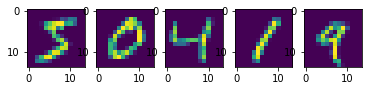

In [6]:
x_train_lr = tf.keras.layers.AveragePooling2D()(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(x_test).numpy()
plotn(5,x_train_lr)

In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy,mse

input_img = Input(shape=(14, 14, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train_lr, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_lr, x_test))

Epoch 1/25
469/469 [==============================] - 6s 10ms/step - loss: 0.3413 - val_loss: 0.1519
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1457 - val_loss: 0.1292
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1273 - val_loss: 0.1202
Epoch 4/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1189 - val_loss: 0.1142
Epoch 5/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1148 - val_loss: 0.1107
Epoch 6/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1115 - val_loss: 0.1083
Epoch 7/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1093 - val_loss: 0.1063
Epoch 8/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1071 - val_loss: 0.1046
Epoch 9/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1060 - val_loss: 0.1037
Epoch 10/25
469/469 [==============================] - 4s 9ms/step - loss: 0.1048 - val_loss: 0.102

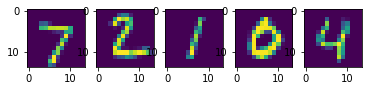

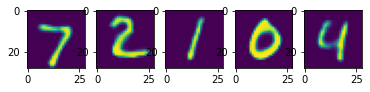

In [9]:
y_test_lr = autoencoder.predict(x_test_lr[0:5])
plotn(5,x_test_lr)
plotn(5,y_test_lr)

> **Задание**: Попробуйте обучить super-resolution на датасете [CIFAR-10](https://keras.io/api/datasets/cifar10/) на увеличение изображения в 2 и в 4 раза, и посмотрите на результат. Попробуйте подавать обученной модели для 4-кратного увеличения на вход белый шум, и посмотрите на результат.

## Variational Autoencoders (VAE)

В предыдущих примерах модель сама училась снижать размерность данных каким-то образом. Чтобы сделать промежуточные данные осмысленными (а модель - *генеративной*), попробуем придать смысл промежуточному слою.

VAE - это автоэнкодер, который в качестве промежуточного слоя использует некоторое распределение вероятностей (*латентное распределение*), и учится параметрам распределения (*латентные переменные*) по входным данным.

Используем латентное распределение $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$, где `z_mean`, `z_log_sigma` $\in\mathbb{R}^d$.

VAE работает примерно следующим образом:

 * По входным данным мы строим вектора `z_mean`, `z_log_sigma`
 * Выбираем набор случайных данных `sample` из $N(\mathrm{z\_mean},e^{\mathrm{z\_log\_sigma}})$
 * По ветору `sample` декодер пытается восстановить исходное изображение.

 <img src="https://github.com/shwars/NeuroWorkshop/raw/master/images/vae.png" width="50%">

In [21]:
intermediate_dim = 512
latent_dim = 2
batch_size = 128

tf.compat.v1.disable_eager_execution()

inputs = Input(shape=(784,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [22]:
@tf.function
def sampling(args):
    z_mean, z_log_sigma = args
    bs = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(bs, latent_dim))
    return z_mean + tf.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [23]:
encoder = Model(inputs, [z_mean, z_log_sigma, z])

latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs)

Для варианционного автоэнкодера используется составная функция потерь, состоящая из двух частей:
* **Reconstruction loss** - показывает, насколько близки изображения, может быть MSE
* **KL loss**, который показывает на близость распределений латентных параметров к нормальным распределениям. Основан на понятии [Kullback-Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) - метрики, оценивающей расхождение двух распределений вероятности.


In [24]:
@tf.function
def vae_loss(x1,x2):
  reconstruction_loss = mse(x1,x2)*784
  tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
  kl_loss = -0.5*tf.reduce_sum(tmp, axis=-1)
  return tf.convert_to_tensor(tf.reduce_mean(reconstruction_loss + kl_loss))

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [25]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train_flat, x_train_flat,
        shuffle=True,
        epochs=25,
        batch_size=batch_size,
        validation_data=(x_test_flat, x_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59520/60000 [============================>.] - ETA: 0s - loss: 48.6396

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 4s 64us/sample - loss: 48.5874 - val_loss: 41.8877
Epoch 2/25
60000/60000 [==============================] - 3s 57us/sample - loss: 41.1296 - val_loss: 40.2556
Epoch 3/25
60000/60000 [==============================] - 3s 56us/sample - loss: 40.0063 - val_loss: 39.3692
Epoch 4/25
60000/60000 [==============================] - 3s 56us/sample - loss: 39.2531 - val_loss: 38.7666
Epoch 5/25
60000/60000 [==============================] - 3s 57us/sample - loss: 38.7147 - val_loss: 38.6124
Epoch 6/25
60000/60000 [==============================] - 3s 57us/sample - loss: 38.2962 - val_loss: 38.1867
Epoch 7/25
60000/60000 [==============================] - 3s 56us/sample - loss: 37.9756 - val_loss: 37.9831
Epoch 8/25
60000/60000 [==============================] - 3s 57us/sample - loss: 37.6933 - val_loss: 37.5475
Epoch 9/25
60000/60000 [==============================] - 3s 57us/sample - loss: 37.4323 - val_loss: 37.2913
Epoch 10/25
60000/60000 [=====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


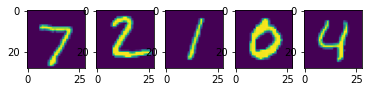

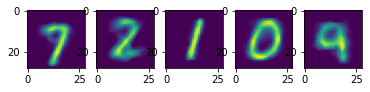

In [26]:
y_test = vae.predict(x_test_flat[0:5])
plotn(5,x_test_flat)
plotn(5,y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


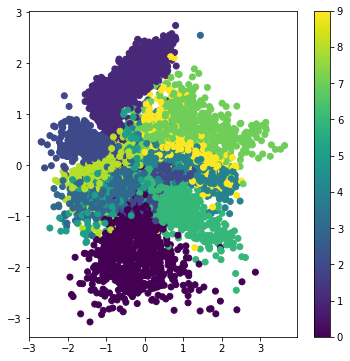

In [27]:
x_test_encoded = encoder.predict(x_test_flat)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_testclass)
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


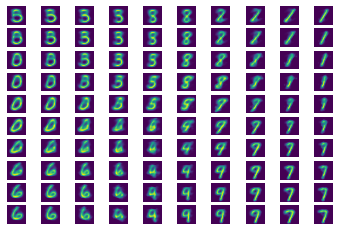

In [28]:
def plotsample(n):
  dx = np.linspace(-1,1,n)
  dy = np.linspace(-1,1,n)
  fig,ax = plt.subplots(n,n)
  for i,xi in enumerate(dx):
    for j,xj in enumerate(dy):
      res = decoder.predict(np.array([xi,xj]).reshape(-1,2))[0]
      ax[i,j].imshow(res.reshape(28,28))
      ax[i,j].axis('off')
  plt.show()
  
plotsample(10)

> **Задание**: Обучите свёрточный вариационный автоэнкодер.

## Дополнительные материалы по теме:

* [Статья на neurohive](https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/)
* [Статья на habr с подробной математикой](https://habr.com/ru/post/331552/)